<a href="https://colab.research.google.com/github/NurlanNKZ/heat-equation-experiments/blob/main/Num_exper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Full module: Convergence analysis of approximation using exact and noisy data

!pip install torch numpy matplotlib plotly tabulate -q

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.6 MB/s eta 0:00:00
Using device: cpu


In [2]:
# Problem parameters
s = 2         # dimension
r = 4         # smoothness
theta = 1.1   # second index
L = 1.0       # domain size
n_max = 7     # maximum order of Fourier coefficients
t_list = [0, 0.001, 0.01, 0.1]      # List of time moments

# Device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Spatial grid
grid_points = 64
x_vals = torch.linspace(0, L, grid_points, device=device)
X, Y = torch.meshgrid(x_vals, x_vals, indexing='ij')
Z = torch.stack((X, Y), dim=-1)

# Helper functions
def get_k(m):
    abs_m = torch.maximum(torch.abs(m), torch.tensor([1], device=device))
    return torch.ceil(torch.log2(abs_m.float())).max(dim=1).int()

def build_Qn(n):
    grid_range = torch.arange(-2**n, 2**n + 1, device=device)
    m1, m2 = torch.meshgrid(grid_range, grid_range, indexing='ij')
    M = torch.stack((m1, m2), dim=-1).reshape(-1, 2)
    return M[torch.any(torch.abs(M) > 1, dim=1)]

def compute_hat_f1(M):
    k_vals = get_k(M)
    coeffs = 2 ** (-k_vals * (r - s/2 + 1/theta))
    return coeffs.to(torch.complex64)

def compute_hat_f(M, r=r, s=s, theta=theta):
    norm_sq = (M.float()**2).sum(dim=1)
    coeffs = 1.0 / (1 + norm_sq)**(r/2 + 1/theta)
    return coeffs.to(torch.complex64)

def aggregate(M, coeffs, Z, t):
    phase = torch.einsum('ij,xyj->ixy', M.float(), Z)
    decay = torch.exp(-4 * np.pi**2 * (M.float()**2).sum(dim=1) * t)
    terms = coeffs * decay
    cos_phase = torch.cos(2 * np.pi * phase)
    sin_phase = torch.sin(2 * np.pi * phase)
    real = torch.sum(cos_phase * terms.real[:, None, None] - sin_phase * terms.imag[:, None, None], dim=0)
    imag = torch.sum(sin_phase * terms.real[:, None, None] + cos_phase * terms.imag[:, None, None], dim=0)
    return torch.complex(real, imag)

def solution(M, coeffs, Z, t):
    return aggregate(M, coeffs, Z, t)

def add_noise(c_exact, eps_n, mode="random", eta_n=None):
    """
    Returns perturbed coefficients c̃_m = c_m + noise
    mode: "random", "systematic", "eta_scaled"
    """
    if mode == "random":
        noise_real = torch.rand_like(c_exact.real) * eps_n
        noise_imag = torch.rand_like(c_exact.imag) * eps_n
        noise = torch.complex(noise_real, noise_imag)
        return c_exact + noise

    elif mode == "systematic":
        noise = torch.complex(
            torch.full_like(c_exact.real, eps_n),
            torch.full_like(c_exact.imag, eps_n)
        )
        return c_exact + noise

    elif mode == "eta_scaled":
        if eta_n is None:
            raise ValueError("eta_n must be specified for eta_scaled noise")
        eps_eta = eps_n * eta_n
        noise = torch.complex(
            torch.full_like(c_exact.real, eps_eta),
            torch.full_like(c_exact.imag, eps_eta)
        )
        return c_exact + noise

    else:
        raise ValueError(f"Unknown noise mode: {mode}")

def compute_L2_error(u_exact, u_approx):
    diff = u_exact - u_approx
    return torch.sqrt((diff * torch.conj(diff)).real.mean()).item()

def compute_max_error(u_exact, u_approx):
    diff = u_exact - u_approx
    return torch.max(diff.real).item()

# Slope estimation (for log-log plot)
def get_slope(x, y):
    return np.polyfit(x, y, deg=1)[0]

def plotly_surface(U, t_val, title_prefix="Exact solution"):
    """
    Interactive 3D plot of Re(u(x, y, t)) using Plotly
    """
    Z_plot = U.real.cpu().numpy() #Z_plot = U.jmag.cpu().numpy(), Z_plot = U.abs().cpu().numpy()
    x_vals = X[:, 0].cpu().numpy()
    y_vals = Y[0, :].cpu().numpy()

    fig = go.Figure(data=[
        go.Surface(z=Z_plot, x=x_vals, y=y_vals, colorscale='Viridis')
    ])

    fig.update_layout(
        title=f"{title_prefix} Re(u(x,y,t={t_val}))",
        scene=dict(
            xaxis_title="x",
            yaxis_title="y",
            zaxis_title="Re(u)",
            aspectratio=dict(x=1, y=1, z=0.5),
        ),
        width=700,
        height=600,
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()

# Main analysis module

def run_convergence_analysis(t=0.01, mode="random", eta_function=None, save_csv=False):
    M_all = build_Qn(n_max)  # fixed large frequency set
    f_hat_all = compute_hat_f(M_all)

    # Convert to numpy
    m1_vals = M_all[:, 0].cpu().numpy()
    m2_vals = M_all[:, 1].cpu().numpy()
    log_abs_fhat = np.log2(torch.abs(f_hat_all).cpu().numpy())

    # 3D plot of log(|f̂(m)|)
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(m1_vals, m2_vals, log_abs_fhat,
                    c=log_abs_fhat, cmap='plasma', s=10, alpha=0.9)

    ax.set_xlabel(r'$m_1$', fontsize=12)
    ax.set_ylabel(r'$m_2$', fontsize=12)
    ax.set_zlabel(r'$\log_{2} |\widehat{f}_{r,\theta}(m)|$', fontsize=14)
    ax.set_title(r'Logarithm of Fourier coefficients $\widehat{f}_{r,\theta}(m)$', fontsize=14)

    # Color scale
    cbar = fig.colorbar(sc, pad=0.1, shrink=0.75)
    cbar.set_label(r'$\log_{2} |\widehat{f}_{r,\theta}(m)|$', fontsize=12)
    plt.tight_layout()
    plt.show()

    if eta_function is None:
        eta_function = lambda n: 2**n + 1

    all_results = []

    for k, t_val in enumerate(t_list):
        results = []
        u_ref = solution(M_all, f_hat_all, Z, t_val).cpu()
        plotly_surface(u_ref, t_val, title_prefix="Exact solution")
        for n in range(2, 7):
            M_n = build_Qn(n)  # truncated set Q_n
            idx = torch.any((M_all[:, None, :] == M_n).all(dim=2), dim=1)
            c_n = f_hat_all[idx]

            eps_n = 1 / (2**(n+1) + 1)**(r + s/2)
            eta_n = eta_function(n)

            phi_exact = aggregate(M_n, c_n, Z, t_val).cpu()
            phi_eps = aggregate(M_n, add_noise(c_n, eps_n, mode=mode), Z, t_val).cpu()
            phi_eta = aggregate(M_n, add_noise(c_n, eps_n, mode="eta_scaled", eta_n=eta_n), Z, t_val).cpu()

            err_exact = compute_L2_error(u_ref, phi_exact)
            err_eps = compute_L2_error(u_ref, phi_eps)
            err_eta = compute_L2_error(u_ref, phi_eta)

            err_exact_max = compute_max_error(u_ref, phi_exact)
            err_eps_max = compute_max_error(u_ref, phi_eps)
            err_eta_max = compute_max_error(u_ref, phi_eta)

            results.append({
                "t": t_val,
                "n": n,
                "N": M_n.shape[0]+9,
                "eps_n": eps_n,
                "eta_n": eta_n,
                "L2_exact": err_exact,
                "L2_eps": err_eps,
                "L2_eta": err_eta,
                'L2_eps/L2_exact': err_eps/err_exact,
                'L2_eta/L2_exact': err_eta/err_exact
                })
        all_results.extend(results)
    df_all = pd.DataFrame(all_results)
    df = df_all[df_all['t'] ==t]
    df['logN'] = np.log10(df['N'])
    df['log_err_exact'] = np.log10(df['L2_exact'])
    df['log_err_eps'] = np.log10(df['L2_eps'])
    df['log_err_eta'] = np.log10(df['L2_eta'])

    # Plot: L2 convergence
    plt.figure(figsize=(10, 6))
    plt.plot(df['logN'], df['log_err_exact'], 'x--', label="Exact")
    plt.plot(df['logN'], df['log_err_eps'], 'o-', label=r"Noise $\varepsilon_n$")
    plt.plot(df['logN'], df['log_err_eta'], 'o-', label=r"Noise $\varepsilon_n \cdot \eta_n$")
    plt.xlabel(r"$\log_{10}(N)$")
    plt.ylabel(r"$\log_{10}(\|u - \varphi_N\|_{L_2})$")
    plt.title(f"Convergence in $L^2$ norm at t = {t}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Slope estimates
    slope_exact = get_slope(df['logN'], df['log_err_exact'])
    slope_eps = get_slope(df['logN'], df['log_err_eps'])
    slope_eta = get_slope(df['logN'], df['log_err_eta'])
    alpha_theor = -(r/s + 0.5)

    # Plot: log-log error slopes with theoretical line
    plt.figure(figsize=(10, 6))
    plt.plot(df['logN'], df['log_err_exact'], 'o-', label=f"Exact, α = {slope_exact:.2f}")
    plt.plot(df['logN'], df['log_err_eps'], 'o-', label=f"Noise εₙ, α = {slope_eps:.2f}")
    plt.plot(df['logN'], df['log_err_eta'], 'o-', label=f"Noise εₙ·ηₙ, α = {slope_eta:.2f}")

    x_line = np.linspace(df['logN'].min(), df['logN'].max(), 100)
    y_line = alpha_theor * x_line + df['log_err_exact'].iloc[0]
    plt.plot(x_line, y_line, '--', color='gray', label=f"Theory: α = {alpha_theor:.2f}")
    plt.xlabel(r"$\log_{10}(N)$")
    plt.ylabel(r"$\log_{10}(\|u - \varphi_N\|_{L_2})$")
    plt.title(f"Convergence order at t = {t}, theoretical: α = {alpha_theor:.2f}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    if save_csv:
        df.to_csv(f"errors_eta_slope_t{t}.csv", index=False)
        print(f"Table saved to errors_eta_slope_t{t}.csv")

    return df_all, slope_exact, slope_eps, slope_eta

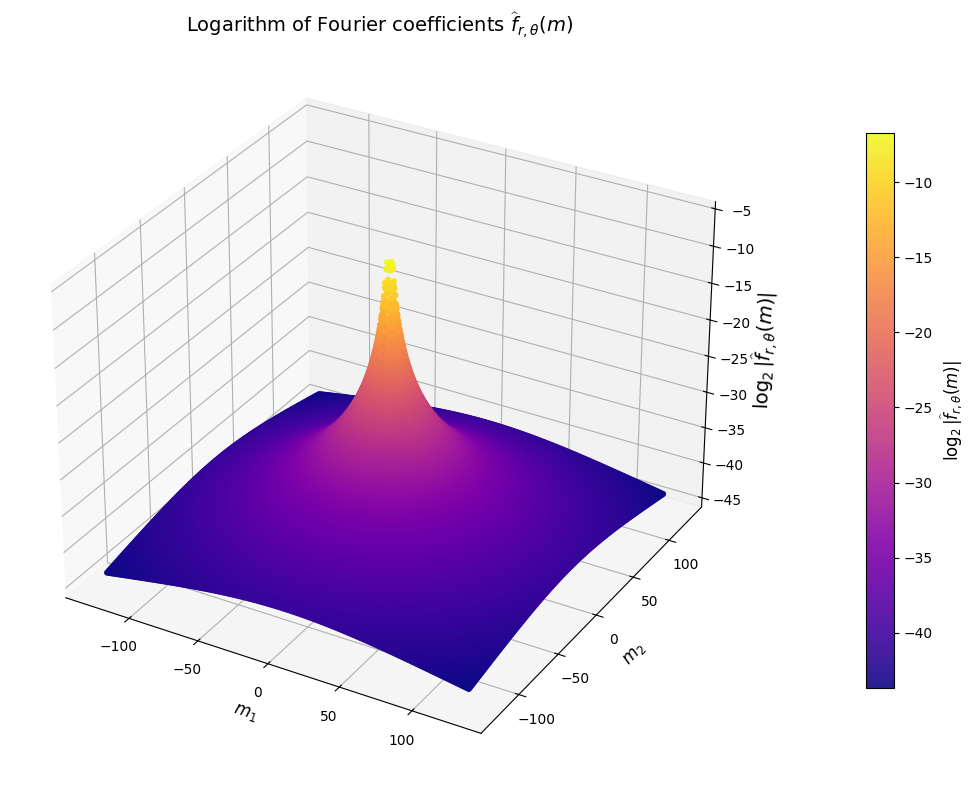

<ipython-input-2-27c719f34788>:195: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-2-27c719f34788>:196: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-2-27c719f34788>:197: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-2-27c71

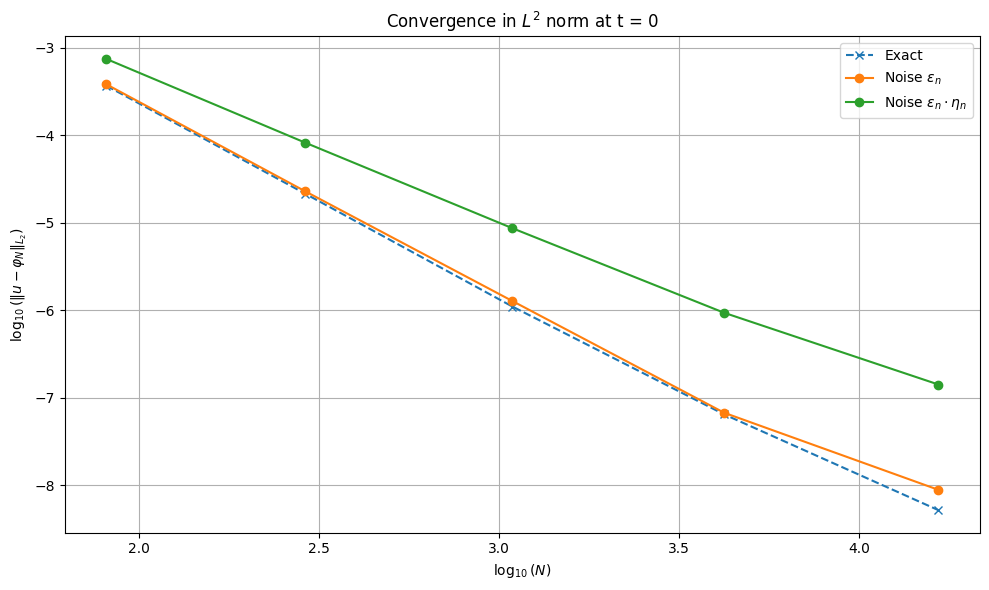

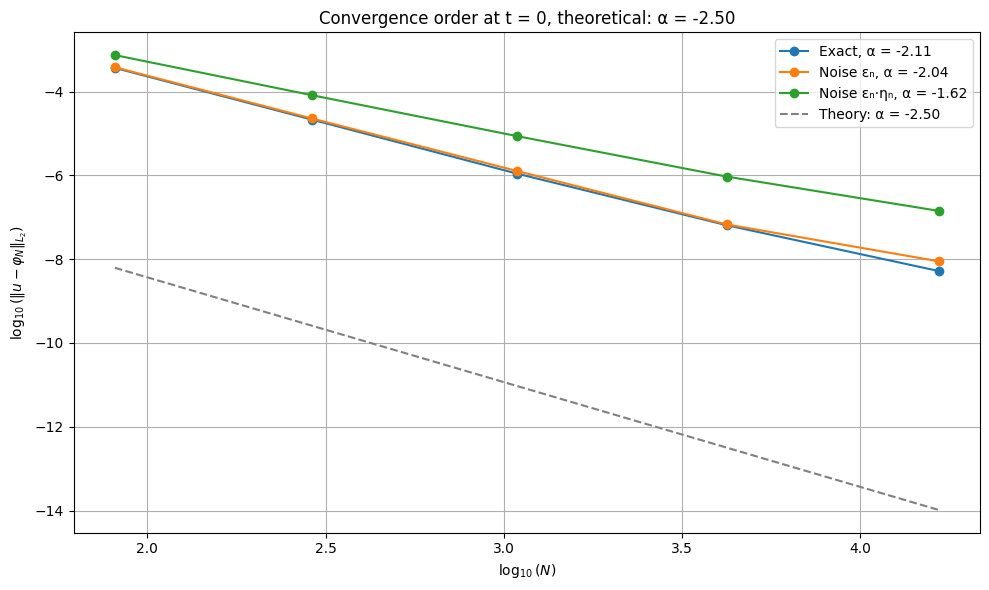

In [3]:
df_all, α1, α2, α3  = run_convergence_analysis(t=0, mode = "random", eta_function = lambda n: n + 1)

In [9]:
t=0

print(f"\nОшибки при t = {t}")
print(df_all[df_all['t'] ==t][['n', 'N', 'eps_n', 'eta_n', 'L2_exact', 'L2_eps', 'L2_eta']].to_markdown(index=False))


Ошибки при t = 0
|   n |     N |       eps_n |   eta_n |    L2_exact |      L2_eps |      L2_eta |
|----:|------:|------------:|--------:|------------:|------------:|------------:|
|   2 |    81 | 1.69351e-05 |       3 | 0.000368715 | 0.000382474 | 0.000745494 |
|   3 |   289 | 7.04296e-07 |       4 | 2.15497e-05 | 2.29543e-05 | 8.25338e-05 |
|   4 |  1089 | 2.55523e-08 |       5 | 1.10541e-06 | 1.27812e-06 | 8.68045e-06 |
|   5 |  4225 | 8.61853e-10 |       6 | 6.47371e-08 | 6.75768e-08 | 9.37882e-07 |
|   6 | 16641 | 2.79931e-11 |       7 | 5.21366e-09 | 8.90325e-09 | 1.42184e-07 |


In [18]:
# Select only the rows with t=0.001, 0.01, 0.1
df_selected = df_all[df_all['t'].isin([0.001, 0.01, 0.1])][['t', 'n', 'N', 'L2_exact']]

# Create a pivot table: rows are (n, N), columns are t
df_pivot = df_selected.pivot(index=['n', 'N'], columns='t', values='L2_exact')

# Reset the index so that n and N become columns again
df_final = df_pivot.reset_index()

# Rename columns for clarity
df_final.columns = ['n', 'N', 't=0.001', 't=0.01', 't=0.1']

# Display the result
import pandas as pd
pd.set_option('display.float_format', '{:.3e}'.format)  # to format numbers nicely
print(df_final)


   n      N   t=0.001    t=0.01     t=0.1
0  2     81 1.148e-04 1.083e-08 1.731e-16
1  3    289 5.376e-07 3.731e-10 1.098e-16
2  4   1089 2.488e-09 1.720e-10 6.759e-17
3  5   4225 2.426e-09 3.023e-10 6.759e-17
4  6  16641 2.231e-09 3.209e-10 6.759e-17
